# Figure 1

I have to use a seperate Jupyter notebook running on a different conda environment with an older Python version to render trees with ete3, because of [this](https://github.com/etetoolkit/ete/issues/296). 

Packages that haven't been maintained for three years with installation documentation not working with Python older than 3.5 (3.11 now) because no one funds these packages writen by grad students! I love bioformatic softwares! 

https://xkcd.com/2347/

In [1]:
%load_ext autoreload
%autoreload 2

import ete3
import os
import pandas as pd, numpy as np
import pickle
import seaborn as sns
import pandas as pd
os.environ['QT_QPA_PLATFORM']='offscreen'

## Trees

In [2]:
def load_taxonomy_file(ff, key='lca_tax_slv'):
    taxa=pd.read_csv(ff)[['name',key]].set_index('name')
    
    def expand_taxonomy(s):
        levels=['kingdom','phylum', 'class', 'order', 'family', 'genus', 'species']
        out={l:'NA' for l in levels}
        split=s.split(';')
        for l,s in zip(levels[:len(split)],split):
            s=s.strip()
            if s:
                out[l]=s
        return out
    taxa=pd.concat([taxa,taxa.apply(lambda row: expand_taxonomy(row[key]),axis=1, result_type='expand')],axis=1)
    taxa.index=taxa.index.str.replace('zeqian_','').str.replace('matti_','').str.replace('bacdive_','')
    return taxa
    

def plot_tree(tree, taxa, colormap, taxa_level='class',w=None,h=None, extend=0.1):
   
    # add fake nodes to the end
    tree=tree.copy()
    total_length=np.max([tree.get_distance(n) for n in tree.get_leaves()])+extend


    for node in tree.get_leaves():
        node.add_child(name='dummy_'+node.name,dist=total_length-tree.get_distance(node))
        # dotted line
        nstyle=ete3.NodeStyle()
        nstyle['fgcolor']=colormap[taxa.loc[node.name,taxa_level]]
        nstyle['bgcolor']=colormap[taxa.loc[node.name,taxa_level]] 
        nstyle['hz_line_type']=2
        # nstyle["size"] = 5
        node.children[0].set_style(nstyle)
    
    for node in tree.traverse():
        if not node.is_leaf():
            ns=ete3.NodeStyle()
            ns['size']=0
            ns['hz_line_width']=2
            node.set_style(ns)


    #tree.ladderize(direction=0)
    ts=ete3.TreeStyle()
    ts.root_opening_factor = 1
    ts.show_leaf_name=False
    ts.branch_vertical_margin=3
    ts.scale=200
    return tree.render("%%inline",tree_style=ts,w=w,h=h)
    
    

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

def plot_growth_data(df,**kwargs):
    df=df.copy()
    fig=plt.figure(figsize=(5,7))
    df[df==1]=2
    df=df.fillna(1)
    sns.heatmap(df,ax=fig.gca(),cmap=ListedColormap(['black','lightgrey','oldlace']), cbar=False,yticklabels=False,**kwargs)
    plt.ylabel(None)
    #plt.xticks(rotation=45,rotation_mode='default')

    return fig

## Plot trees 

In [56]:
zeqian=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian.pk")
zeqian_tree=zeqian['tree']
zeqian_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian_16S.aligned.csv")

matti=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/matti/matti.pk")
matti_tree=matti['tree']
matti_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/matti/matti_16S.aligned.csv")


In [57]:

level='class'
all_classes=np.union1d(zeqian_taxa[level],matti_taxa[level])
sample_count=pd.Series(0,index=all_classes)
for df in [zeqian_taxa, matti_taxa]:
    vc=df[level].value_counts()
    sample_count.loc[vc.index.values]+=vc.values
sample_count.sort_values(ascending=False, inplace=True)

colors = sns.color_palette("colorblind").as_hex()
colors.pop(7) # remove grey 

colormap=dict(zip(sample_count.index.values, colors[:sample_count.shape[0]]))


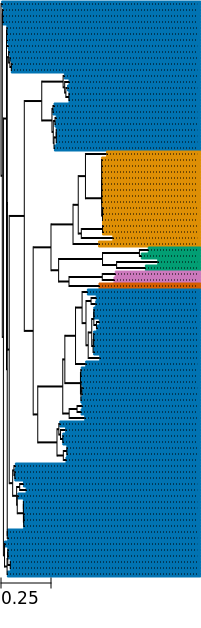

In [58]:
fig_tree=plot_tree(zeqian_tree,zeqian_taxa, colormap=colormap, taxa_level=level,extend=0.2)
fig_tree

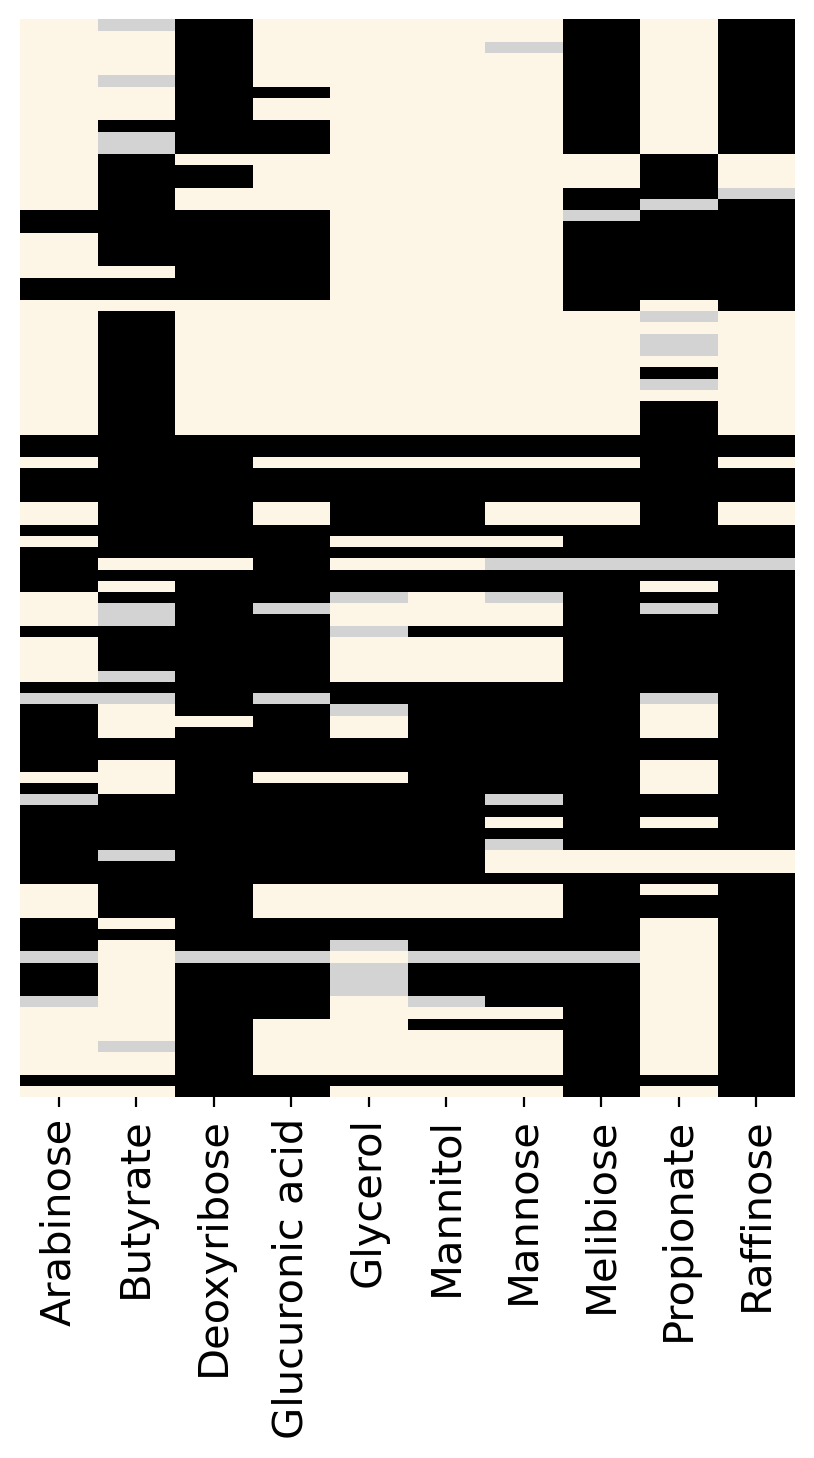

In [59]:
fig_growth=plot_growth_data(zeqian['growth_data'].loc[[n.name for n in zeqian_tree.get_leaves()],:])

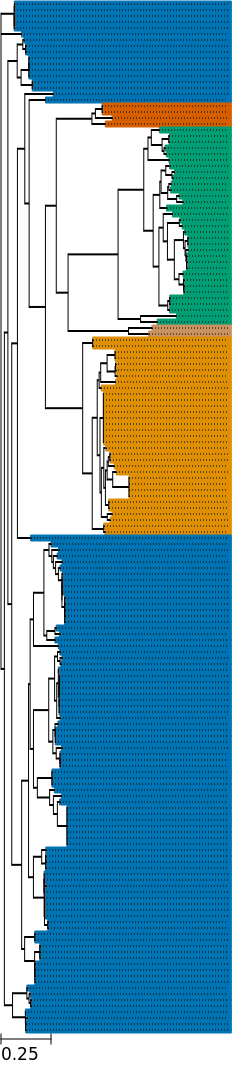

In [60]:
fig_tree=plot_tree(matti_tree,matti_taxa, colormap=colormap, taxa_level=level,extend=0.2)
fig_tree

In [73]:
len(matti['samples'])

172

In [6]:
import  scipy.cluster.hierarchy as  hierarchy

def cluster_matrix(matrix, axis=0, metric=None, **kwargs):
    """ Hierarchical cluster a matrix. 
    
    """
    if axis == 1:
        return cluster_matrix(matrix.T, axis=0, metric=metric, **kwargs).T

    if metric is None:
        def metric(x, y):
            x = (x > 0).astype(int)
            y = (y > 0).astype(int)
            # -np.logical_and(np.isnan(x),np.isnan(y)).sum())
            return 1-(x == y).sum()/len(x)
    Z = hierarchy.linkage(matrix, metric=metric, **kwargs)

    return matrix.iloc[hierarchy.leaves_list(Z), :]


In [ ]:
fig_growth=plot_growth_data(cluster_matrix(matti['growth_data'].loc[[n.name for n in matti_tree.get_leaves()],:],axis=1),xticklabels=False)

# BacDive

In [4]:
bacdive=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")

Text(0.5, 133.16666666666663, '')

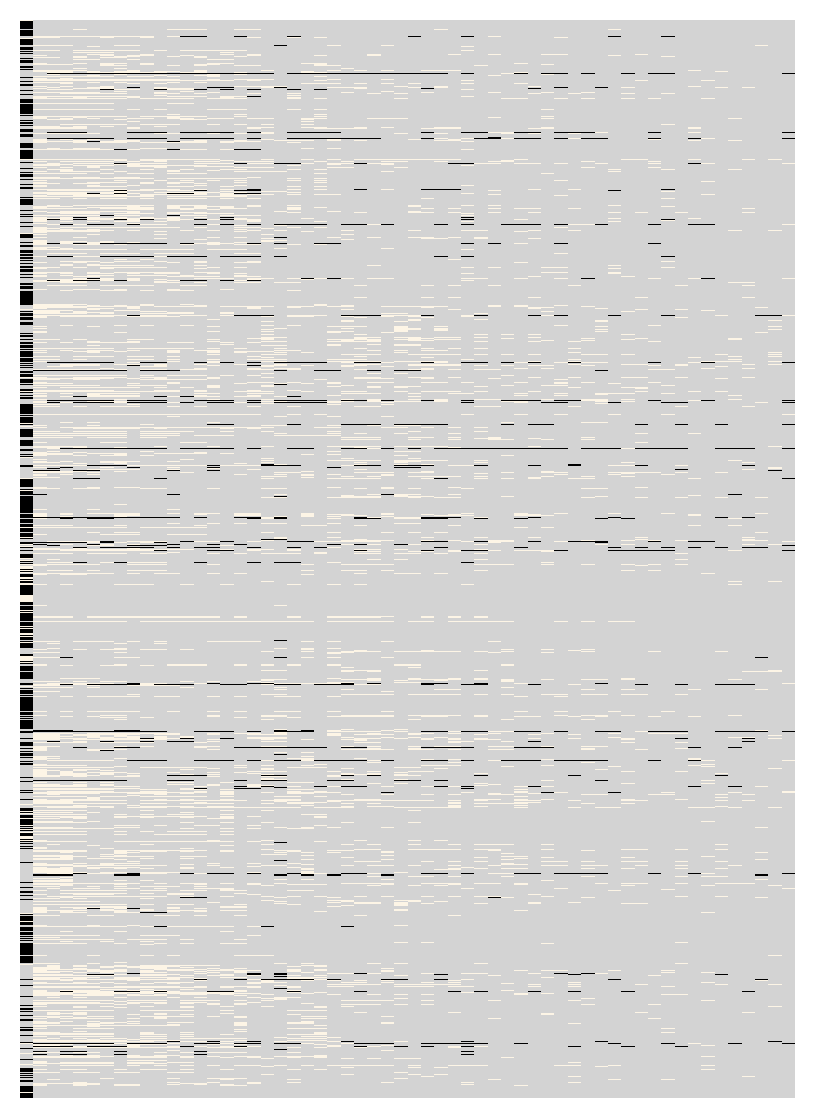

In [9]:
# Bacdive
df=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")['growth_data']
df=df.iloc[:,np.argsort(df.count(axis=0).values)[::-1]]
# df=cluster_matrix(df,axis=0)
df=df.loc[[n.name for n in bacdive['tree'].get_leaves()],:]

#fig=plot_growth_data(df.iloc[np.random.choice(df.shape[0],500),:30])
fig_growth=plot_growth_data(df,xticklabels=False)

plt.xlabel(None)

In [3]:
# bacdive tree

In [6]:
tree

Tree node '' (0x7f2a50480c1)

In [10]:
tree.get_leaves()

[Tree node '15220' (0x7f27ff2b525),
 Tree node '15154' (0x7f27ff2b5a3),
 Tree node '16376' (0x7f27ff1bca3),
 Tree node '15040' (0x7f27ed726ca),
 Tree node '16196' (0x7f27ed726c4),
 Tree node '16034' (0x7f27ed73d5b),
 Tree node '15568' (0x7f27ed73d5e),
 Tree node '15276' (0x7f27ed75437),
 Tree node '15586' (0x7f27ed75458),
 Tree node '133062' (0x7f27ed754ca),
 Tree node '7481' (0x7f27ed6f110),
 Tree node '7452' (0x7f27ed6f1cd),
 Tree node '7424' (0x7f27ed7084c),
 Tree node '24187' (0x7f27ed6a216),
 Tree node '7491' (0x7f27ed6a234),
 Tree node '7324' (0x7f27ed6f149),
 Tree node '7480' (0x7f27ed6f11f),
 Tree node '7794' (0x7f27ed6a2c4),
 Tree node '7756' (0x7f27ed6ba9d),
 Tree node '7576' (0x7f27ed6bafd),
 Tree node '7662' (0x7f27ed6ba43),
 Tree node '7663' (0x7f27ed6ba49),
 Tree node '1868' (0x7f27ed6a279),
 Tree node '22938' (0x7f27ed6a282),
 Tree node '161' (0x7f27ed6d4e5),
 Tree node '190' (0x7f27ed66f19),
 Tree node '206' (0x7f27ed66f3a),
 Tree node '209' (0x7f27ed66f49),
 Tree node 

In [28]:
bacdive=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")

tree=bacdive['tree'].copy()
leaves=[n.name for n in tree.get_leaves() if tree.get_distance(n.name)<40]
tree.prune(leaves, preserve_branch_length=True)


In [2]:

highlight=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/better_strains.pk")
hightlight=highlight[highlight>0.5]

In [3]:
highlight

10434     1.000000
13413     1.000000
11267     1.000000
146183    1.000000
13298     1.000000
            ...   
4940      0.244048
158416    0.230769
1616      0.200000
5051      0.142857
2872      0.111111
Length: 195, dtype: float64

In [29]:


bacdive_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive_16S.aligned.csv")
orders=['Enterobacterales','Pseudonocardiales']
taxa_highlights=[bacdive_taxa[bacdive_taxa['order']==order].index.values for order in orders]

In [30]:
for node in tree.get_leaves():
    if node.name in taxa_highlights[0]:
        ns=ete3.NodeStyle()
        ns['bgcolor']='blue'
        ns['size']=5
        node.set_style(ns)
    
    if node.name in taxa_highlights[1]:
        ns=ete3.NodeStyle()
        ns['bgcolor']='green'
        ns['size']=5
        node.set_style(ns)
    

In [31]:
for n, value in highlight.items():
    node=tree.get_leaves_by_name(n)[0]
    ns=ete3.NodeStyle()
    
    ns['bgcolor']='red'
    ns['size']=20
    node.set_style(ns)

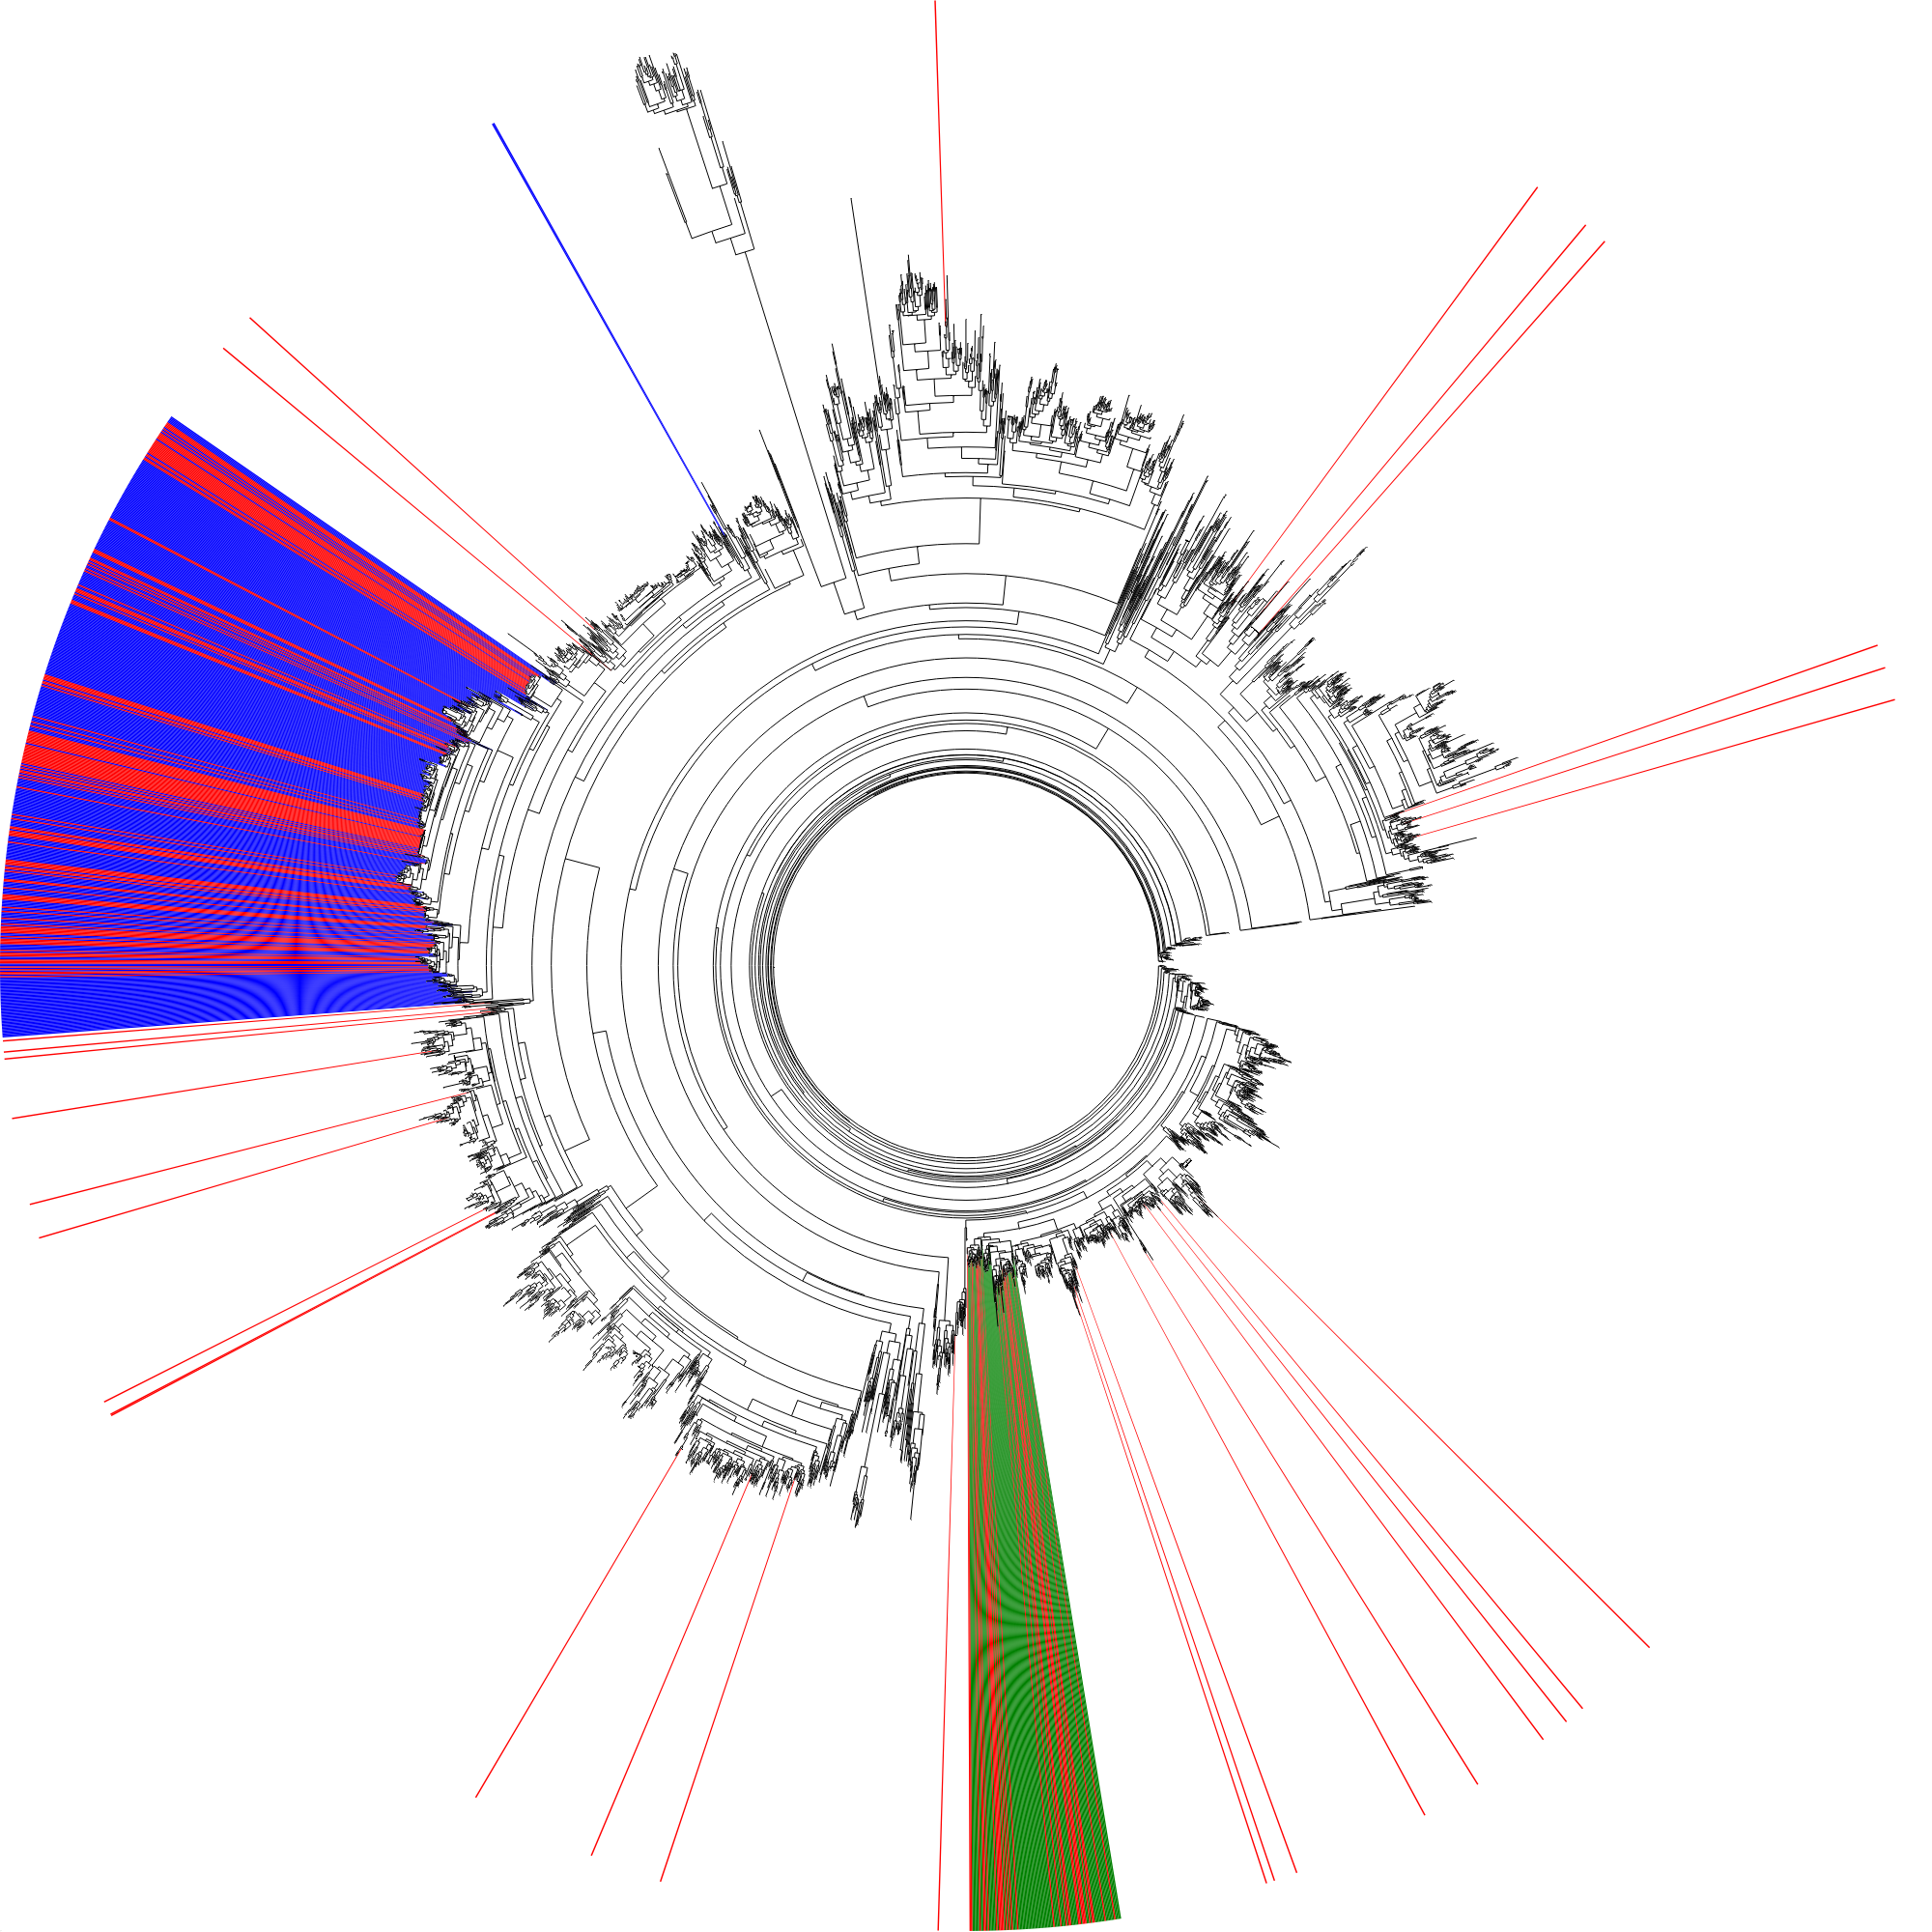

In [32]:
ts=ete3.TreeStyle()

ts.show_leaf_name=False
ts.mode = "c"
# ts.arc_start = -180 # 0 degrees = 3 o'clock
# ts.arc_span = 180
tree.render("%%inline",tree_style=ts,w=2000,h=2000)

In [25]:
leaves

array(['7181', '18105'], dtype='<U6')

# Archive

In [36]:
  
#     common_ancestors=[]
#     for t,color in colormap.items():
#         df=taxa[taxa[taxa_level]==t]
#         if df.shape[0]>0:
#             n=tree.get_common_ancestor(*df.index.values)
#             common_ancestors.append((n, color))
# for n, c in common_ancestors:
#     print(len(n.get_leaves()))
#     ns=ete3.NodeStyle()
#     ns['size']=0
#     ns['hz_line_width']=2
#     ns['bgcolor']=c
#     node.set_style(ns)